In [1]:
from madhatter import *
from madhatter.loaders import *

from nltk.corpus import gutenberg
from nltk.corpus import europarl_raw

import pandas as pd
from multiprocess.pool import Pool
# A progress bar to try to give an overall idea of the progress made.
from tqdm import tqdm
import pickle
from pathlib import Path
from os import path

input_length = 100_000


In [2]:
# nlp = spacy.load("en_core_web_sm", disable=[
#                  "ner",
#                  #  "lemmatizer",
#                  "textcat", "attribute_ruler"])
# nlp.pipe_names


def read_texts(path: Path | str, length: int = 1_000_000) -> list[str]:
    """Returns a list of strings sequentially read from the path specified as the option. 

    Parameters
    ----------
    path : Path
        Path to read from. The document will be opened in text-mode.
    length : int, optional
        The desired length of all texts, by default 1_000_000

    Returns
    -------
    list[str]
        List of the read character sequences.
    """
    with open(path) as f:
        text = []
        line = f.read(length)
        while len(line) > 0:
            text.append(line)
            line = f.read(length)
    return text


def split_strings(string: str, length=1_000_000):
    ret = []
    i = 0
    read = string[i*length:(i+1)*length]
    while len(read) > 0:
        ret.append(read)
        i += 1
        read = string[i*length:(i+1)*length]
    return ret


SpaCy performance concerns

| Processes | Total Time (s) | Peak Total Memory (MB) |
| --- | --- | --- |
| 1 (SpaCy pipe) | 25.104 | 6487 |
| 16 (SpaCy pipe) | 45.345 | 6340 |
| 16 (multiprocessing) | 8.313 | 6679 |


### Memory usage of Spacy vs Custom Package
| Framework | peak memory | increment |
|-----------|-------------|-----------|
| Spacy | 5089.13 MiB |  4465.29 MiB |
| Mad Hatter| 434.81 MiB  | 48.75 MiB |

Increment here is the more important number as it tells us how memory usage peaks when performing a given operation.


## Experimentation with pipelines
Here we prepare a pipeline that will take the list of resources and return a list of `Report` objects. Those `Report` objects are then fed into a Pandas dataframe for further analysis. For better performance, we use the `multiprocessing` module to parallelize the pipeline, as each text is largely independent.


Example listing of the pipeline:
```python
def pipeline(resources: list[str]):
    reports = []
    for resource in resources:
        report = Report(resource)
        reports.append(report)
    return reports
```

In [23]:
def process(file: str, title: str | None = None) -> Report:
    try:
        return CreativityBenchmark(file, title if title is not None else "unknown").report(print_time=False, postag_distribution=True)
    except:
        return Report('', None, None, None, None, None, None, None, None, None)


def process_texts(args, processes: int = 16):
    """Note: args should be of the form (file, title if any)"""
    with Pool(processes) as p:
        return p.starmap(process, tqdm(args, total=len(args)))


def save_results(results, savepath):
    with open(savepath, 'wb') as file:
        pickle.dump(results, file)


def load_results(savepath):
    with open(savepath, 'rb') as file:
        return pickle.load(file)


## Measuring the Gutenberg/Fiction dataset
Note the lack of variety here. Gutenberg only has 18 works, but they lead to 2124 texts of length 100000. This may be a somewhat flawed methodology so I recommend exploring more fictional works.

2124


,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,mean_freq,prop_pos,class
0,austen-emma.txt,20736,3.944541,110.286674,24.076148,0.602334,2.736829,3.338598,-2.373265,"{'NOUN': 0.17213953488372094, 'VERB': 0.180976...",1
1,austen-emma.txt,21070,3.874798,110.817568,24.546171,0.600237,2.744145,3.407837,-2.375355,"{'NOUN': 0.16750011469468276, 'VERB': 0.177042...",1
2,austen-emma.txt,20499,3.996878,146.833581,31.341753,0.578370,2.679235,3.276575,-2.343437,"{'VERB': 0.18124496278386196, 'NOUN': 0.170293...",1
3,austen-emma.txt,20905,3.920497,124.547980,27.282828,0.606553,2.733417,3.331522,-2.376738,"{'NOUN': 0.16591077378748612, 'VERB': 0.189374...",1
4,austen-emma.txt,21117,3.873325,97.063241,21.721344,0.630487,2.727581,3.265606,-2.399655,"{'NOUN': 0.16577199526885633, 'VERB': 0.188199...",1


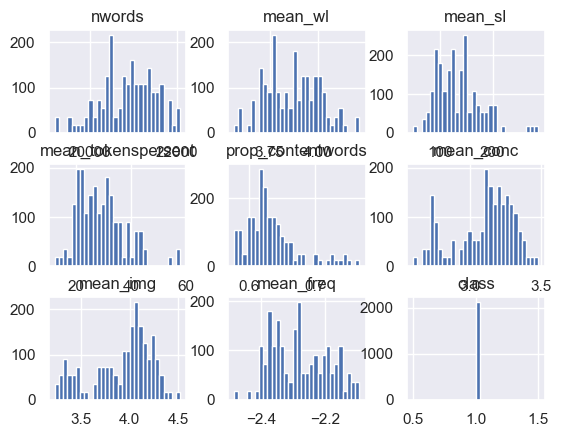

In [4]:
creative_fns = [file for file in gutenberg.fileids()]
creative_files = []
for file in creative_fns:
    listt = split_strings(gutenberg.raw(creative_fns), length=input_length)
    creative_files.extend([(_, file) for _ in listt])

print(len(creative_files))

savepath_creative = Path("./results/.creative")

if savepath_creative.exists():
    creative_results = load_results(savepath_creative)
else:
    creative_results = process_texts(creative_files)
    save_results(creative_results, savepath_creative)

creative_df = pd.DataFrame(creative_results)
creative_df.insert(creative_df.shape[1], "class", 1)

creative_df.hist(bins=30)
creative_df.head()


## Loading legal datasets into the pipeline

,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,mean_freq,prop_pos,class
0,legal_text_0,18053,4.672464,652.601307,118.921569,0.686146,3.016673,4.358274,-2.086670,"{'NOUN': 0.37032151690024734, 'VERB': 0.078428...",2
1,legal_text_1,17597,4.775530,394.260870,70.438735,0.655396,2.973358,4.090671,-2.138984,"{'VERB': 0.08041075136075417, 'NOUN': 0.355367...",2
2,legal_text_2,17652,4.777872,422.733051,75.788136,0.686891,3.024933,4.169661,-2.123103,"{'ADJ': 0.044727720004472775, 'NOUN': 0.378172...",2
3,legal_text_3,18013,4.673569,486.809756,88.814634,0.683451,2.900618,4.209920,-2.122910,"{'VERB': 0.08776844070961717, 'NOUN': 0.373977...",2
4,legal_text_4,17695,4.737157,410.522634,73.522634,0.627804,2.966905,4.149116,-2.109856,"{'NOUN': 0.34081495578193216, 'VERB': 0.090619...",2


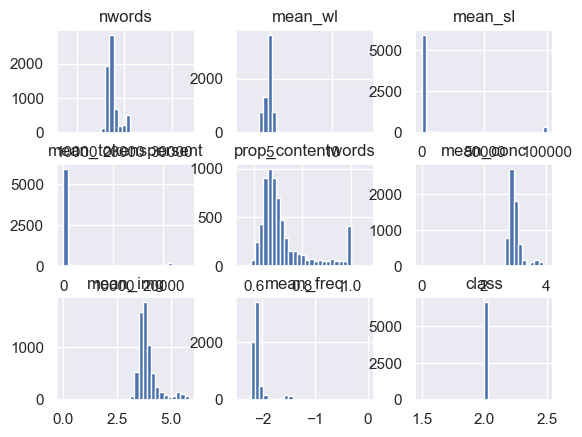

In [5]:
legal_path = Path("./results/.legal")
if legal_path.exists():
    legal_results = load_results(legal_path)
else:
        
    legal_texts = read_texts(ds_dgt(), length=input_length)

    europarl_txt = split_strings("".join([" ".join(
        [" ".join(para) for para in chap]) for chap in europarl_raw.english.chapters()]), length=input_length)
    legal_texts.extend(europarl_txt)

    legal_results = process_texts(
        [(legal_text, f"legal_text_{i}") for i, legal_text in enumerate(legal_texts)])
    
    save_results(legal_results, legal_path)

legal_df = pd.DataFrame(legal_results)
legal_df.insert(legal_df.shape[1], "class", 2)

legal_df.hist(bins=30)
legal_df.head()


## Loading writing prompts

,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,mean_freq,prop_pos,class
0,writingprompts_0,22315,3.571230,72.260806,16.353114,0.698812,3.228014,3.993187,-2.310648,"{'ADJ': 0.07839799301137891, 'NOUN': 0.2622076...",3
1,writingprompts_1,22543,3.525352,66.204973,15.162634,0.693475,3.219386,3.998758,-2.318405,"{'NOUN': 0.26163460686109385, 'VERB': 0.165100...",3
2,writingprompts_2,21895,3.647910,78.745614,17.480861,0.681297,3.262477,4.073366,-2.311806,"{'VERB': 0.1637242826513389, 'ADJ': 0.07668445...",3
3,writingprompts_3,22261,3.595571,68.348821,15.459085,0.706662,3.160694,4.004470,-2.270799,"{'ADJ': 0.08038758298941324, 'NOUN': 0.2839583...",3
4,writingprompts_4,22822,3.474805,70.736011,16.406026,0.695031,3.277664,4.056539,-2.341960,"{'NOUN': 0.26628771316134675, 'ADJ': 0.0786182...",3


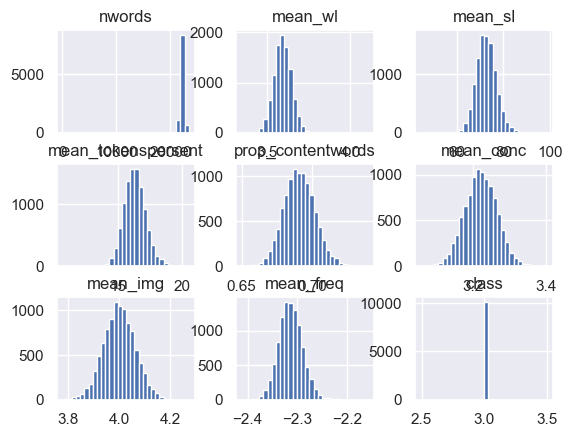

In [6]:
wp_savepath = Path("./results/.wp")
if wp_savepath.exists():
    wp_results = load_results(wp_savepath)
else:
    # TODO: Possibly try out stuff like actually splitting the writingprompts dataset instead of reading continuous text.

    wp_path = ds_writingprompts()
    writingprompts = read_texts(wp_path["train"][1], length=input_length)
    writingprompts.extend(read_texts(wp_path["test"][1], length=input_length))
    writingprompts.extend(read_texts(wp_path["val"][1], length=input_length))

    wp_results = process_texts(
        list((_, f"writingprompts_{i}") for i, _ in enumerate(writingprompts)))

    # Length (100_000 chars) = 100089
    print(f"Length of writingprompts dataset: {len(writingprompts)}")
    # Whole thing took around 35 minutes on battery charge
    save_results(wp_results, wp_savepath)


writingprompts_df = pd.DataFrame(wp_results)
writingprompts_df.insert(writingprompts_df.shape[1], "class", 3)

writingprompts_df.hist(bins=30)
writingprompts_df.head()


array([[<AxesSubplot: title={'center': 'nwords'}>,
        <AxesSubplot: title={'center': 'mean_wl'}>,
        <AxesSubplot: title={'center': 'mean_sl'}>],
       [<AxesSubplot: title={'center': 'mean_tokenspersent'}>,
        <AxesSubplot: title={'center': 'prop_contentwords'}>,
        <AxesSubplot: title={'center': 'mean_conc'}>],
       [<AxesSubplot: title={'center': 'mean_img'}>,
        <AxesSubplot: title={'center': 'mean_freq'}>,
        <AxesSubplot: title={'center': 'class'}>]], dtype=object)

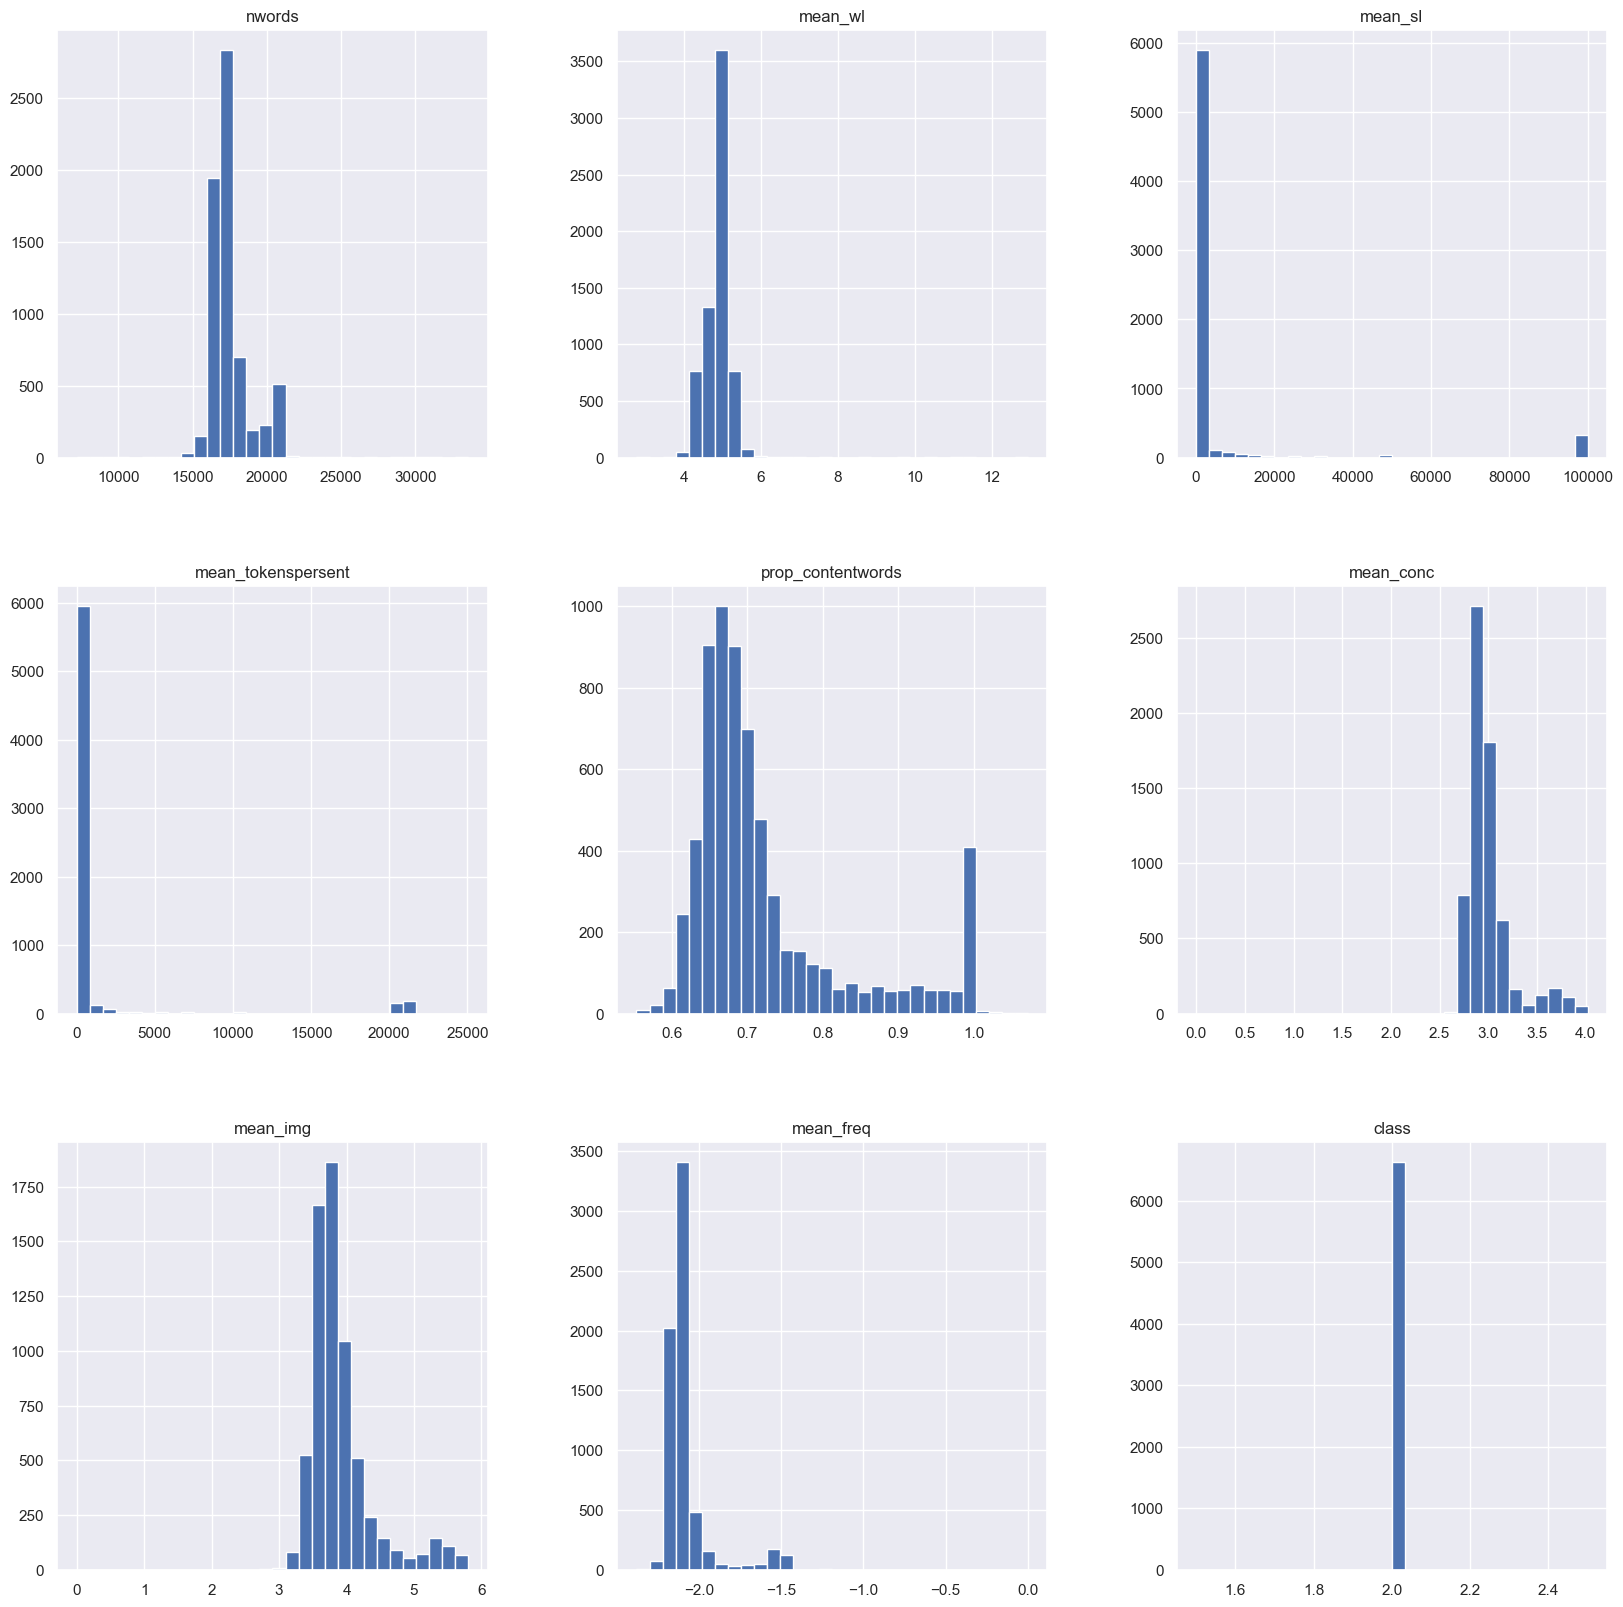

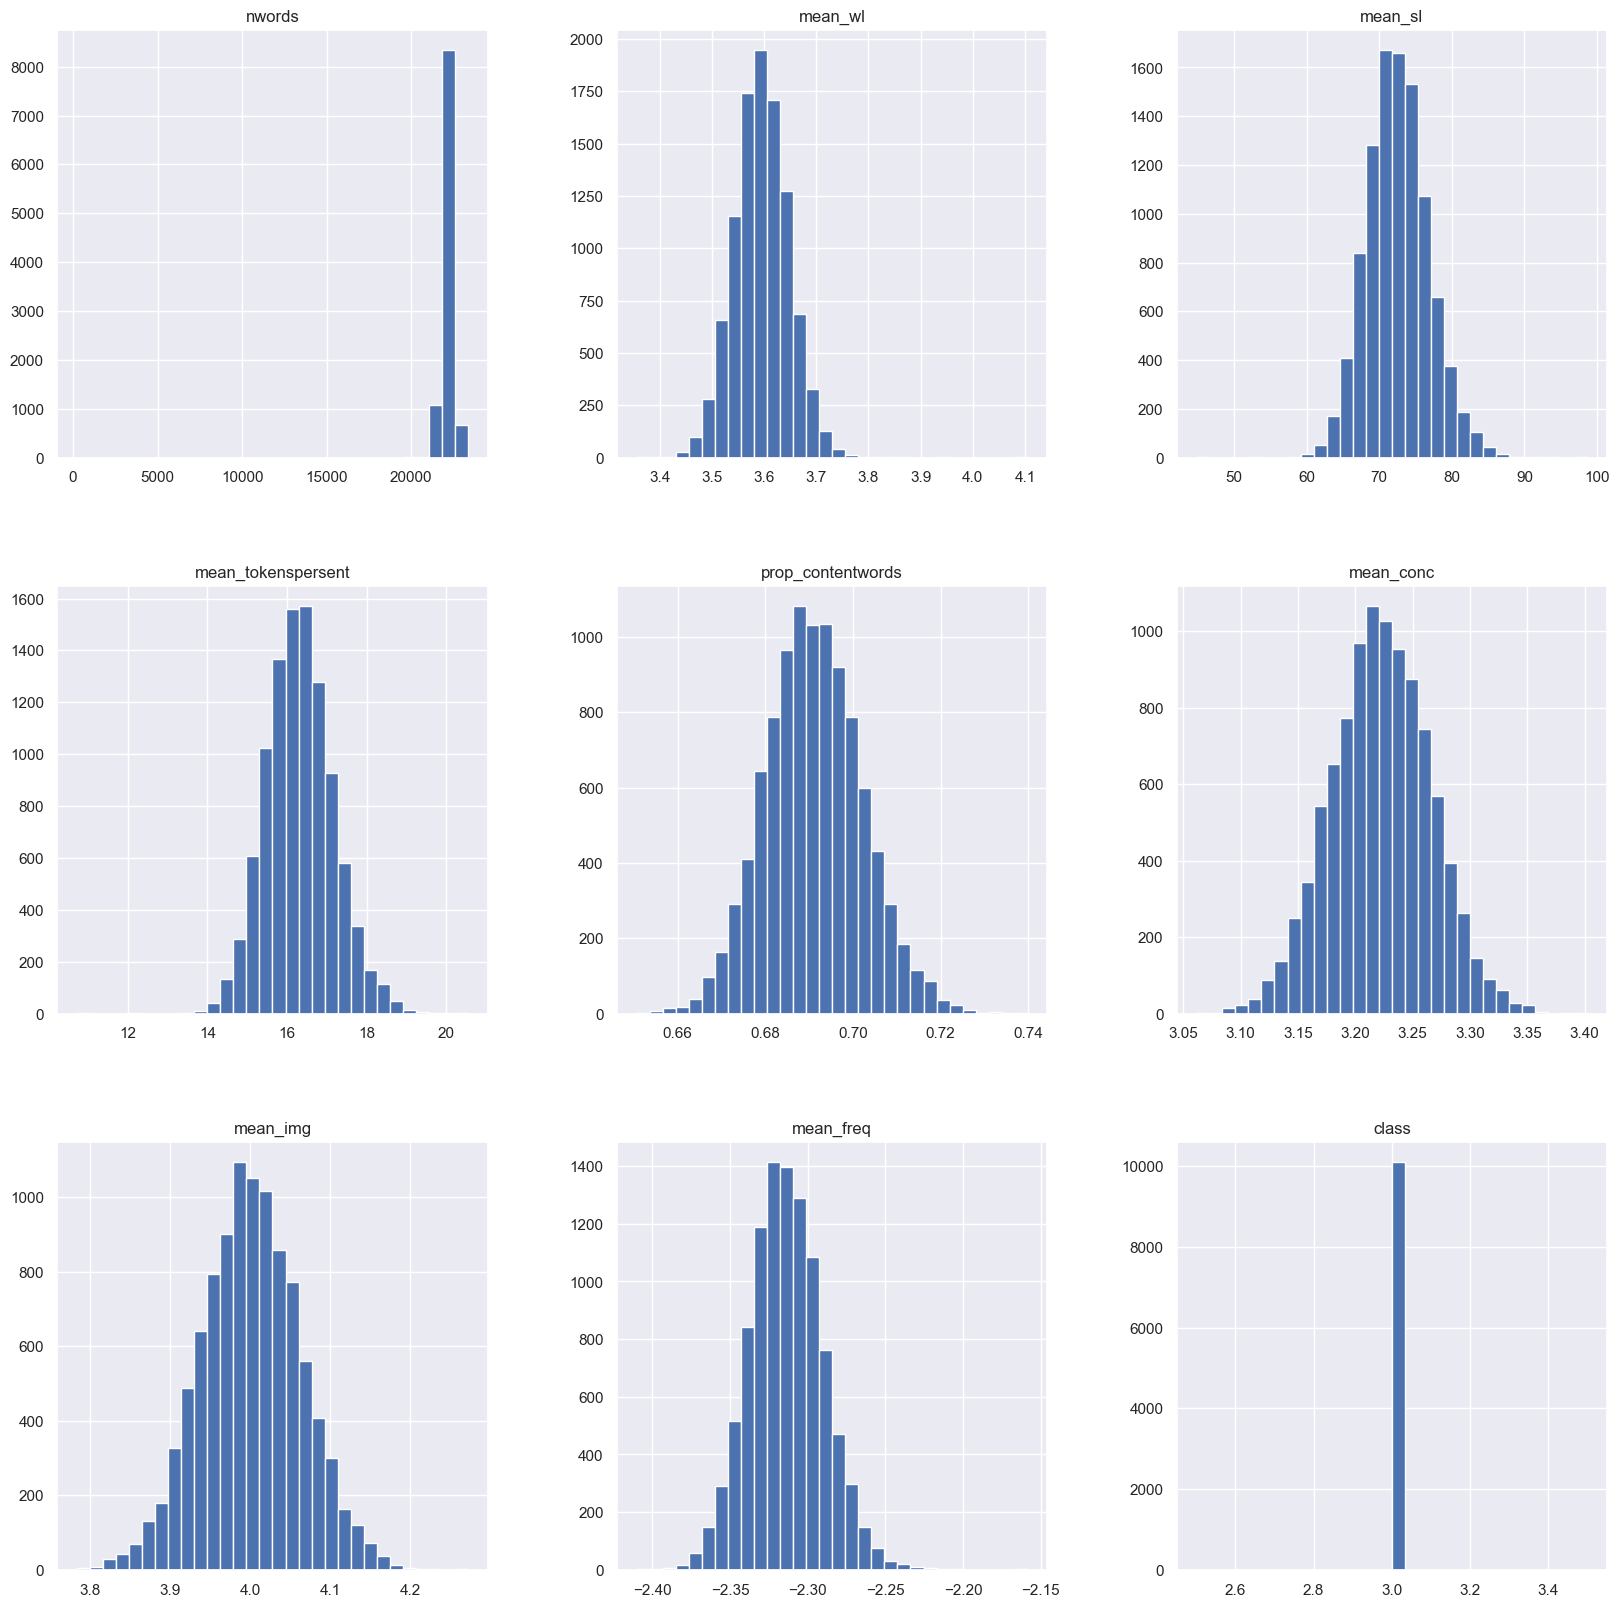

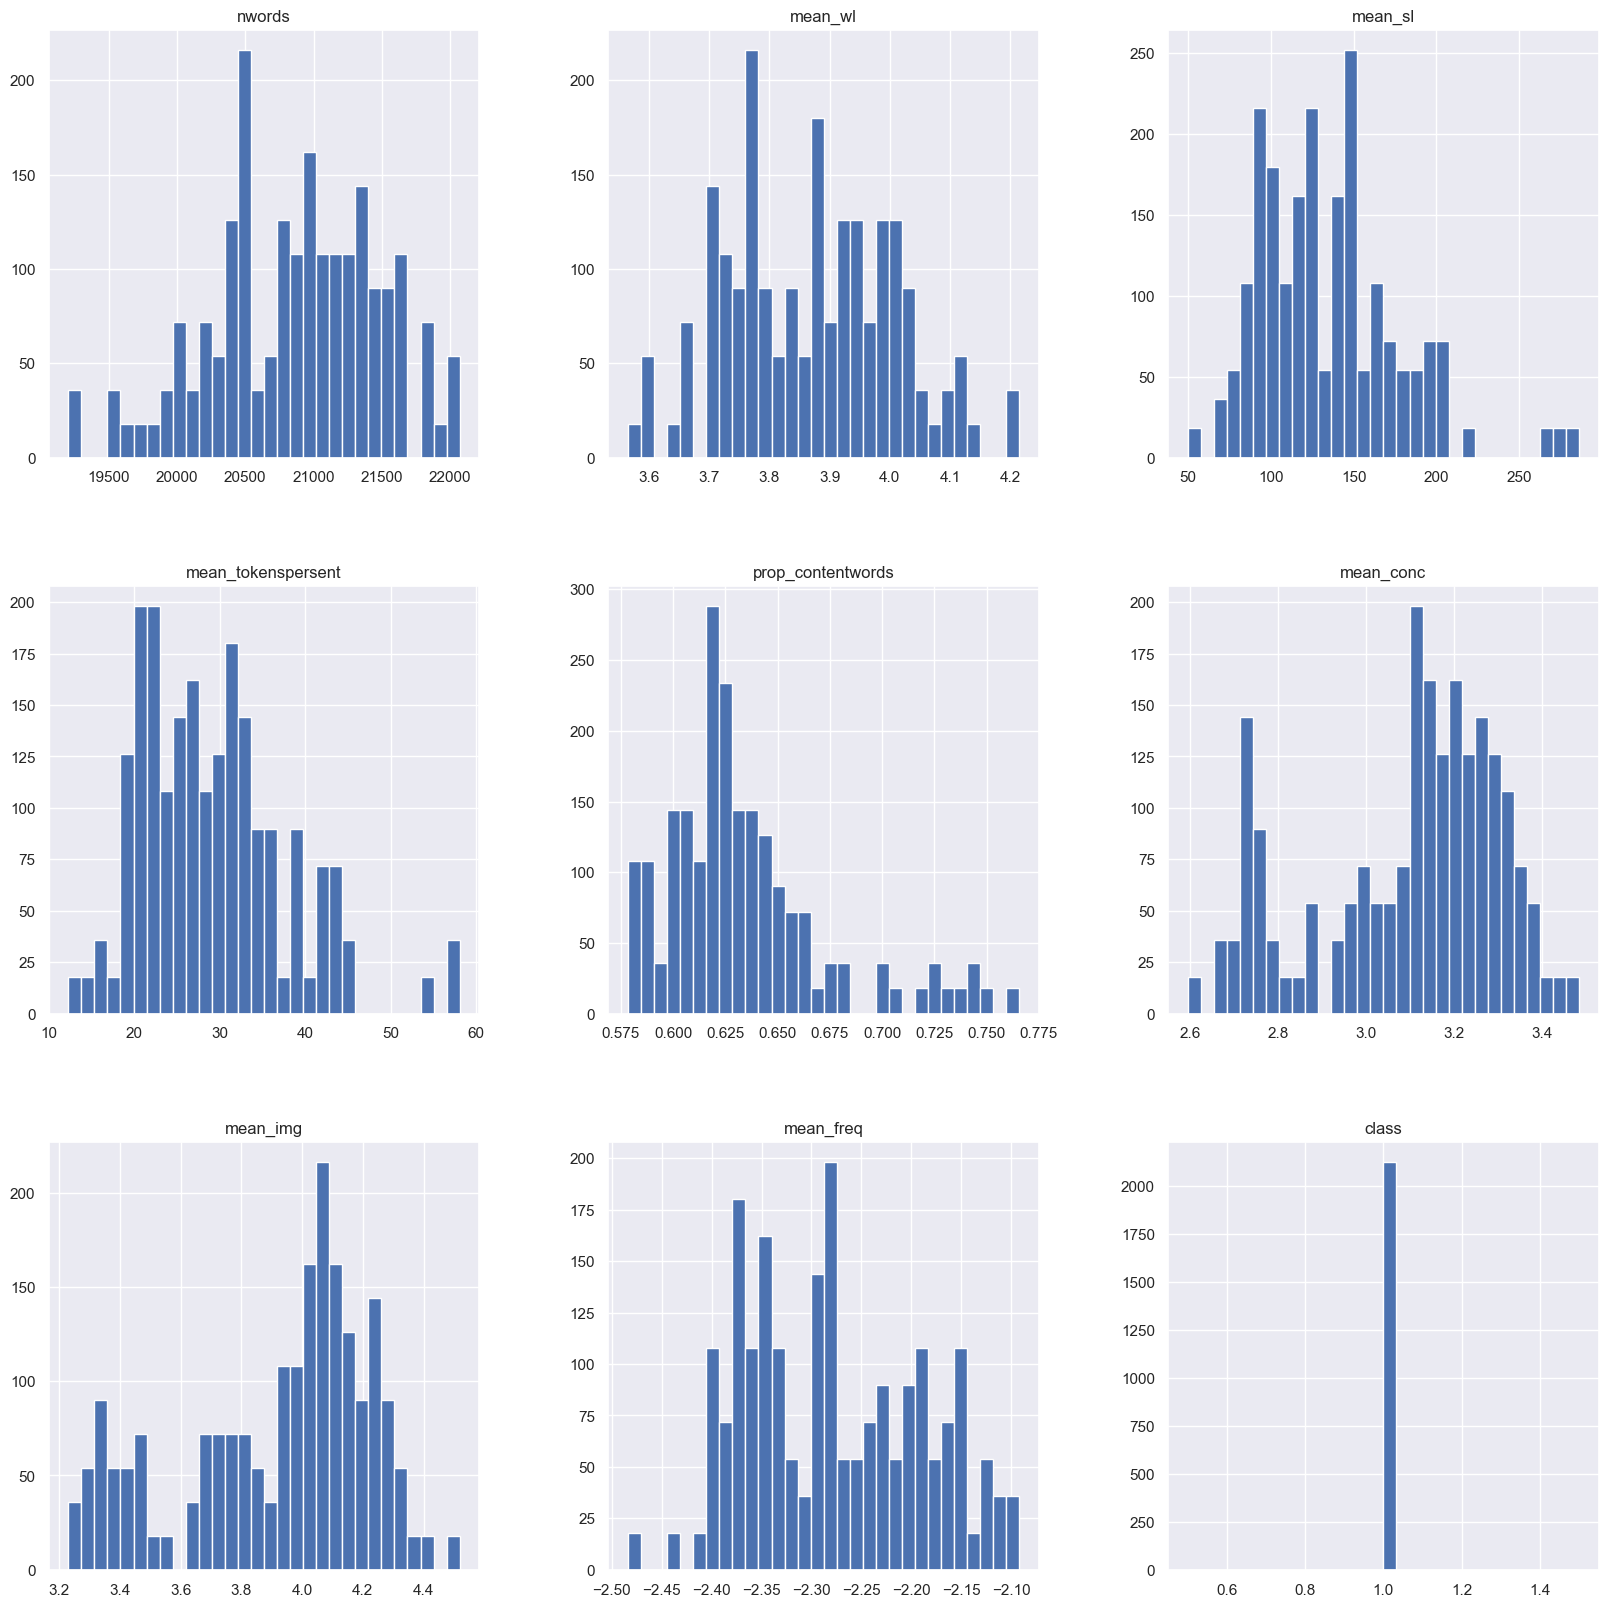

In [7]:
legal_df.hist(bins=30, figsize=(20,20))
writingprompts_df.hist(bins=30, figsize=(20,20))
creative_df.hist(bins=30, figsize=(20,20))

A little visualization of what is happening behind the scenes. It seems like the novels have quite a bit more variety behind them at first glance. 

## Experiment


After running the pipeline, we concatenate the results into a single dataframe which we can then use for further analysis. 

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Join
df = pd.concat([creative_df.head(2000), writingprompts_df.head(2000), legal_df.head(2000)], ignore_index=True)
df = df.join(pd.json_normalize(df["prop_pos"]).fillna(0.0))  # type: ignore

# drop unneeded columns and select features
xdf = df.drop(["title", "class", "prop_pos"], axis=1)

# drop arbitrary columns to see how results change
xdf = xdf.drop([
    "nwords",
    "mean_wl", 
    "mean_sl",
    
                 "NOUN", 
                 "ADJ", 
                "VERB", 
                # "mean_conc", "mean_img", "mean_freq", 
                 
                "prop_contentwords", 
                "mean_tokenspersent"
                ], axis=1)
ydf = df["class"]

# make the splits
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, test_size=0.1)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1)

# create the pipeline
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(xtrain, ytrain)  # apply scaling on training data


# test the scoring
print(f"Val split score: {pipe.score(xval, yval):.5f}")
print(f"Test split score: {pipe.score(xtest, ytest):.5f}")

confusion_matrix(pipe.predict(xtest), ytest)

Val split score: 0.85000
Test split score: 0.82000


array([[120,   4,  16],
       [ 21, 184,   0],
       [ 67,   0, 188]])

KeyboardInterrupt: 

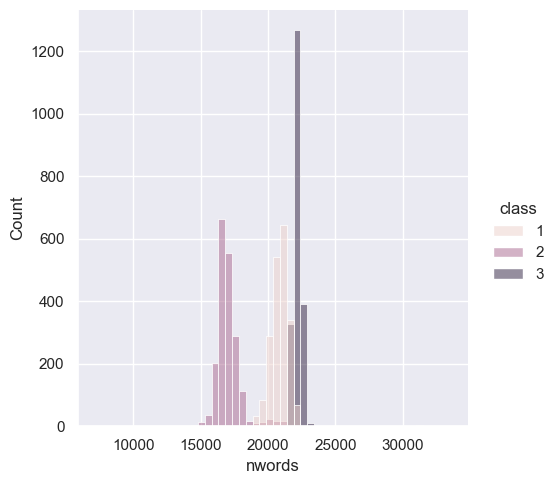

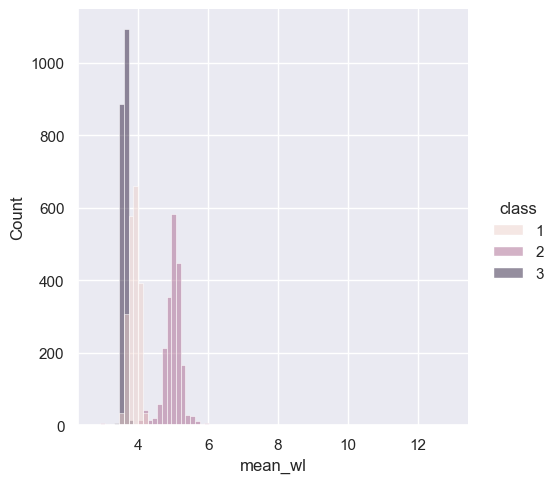

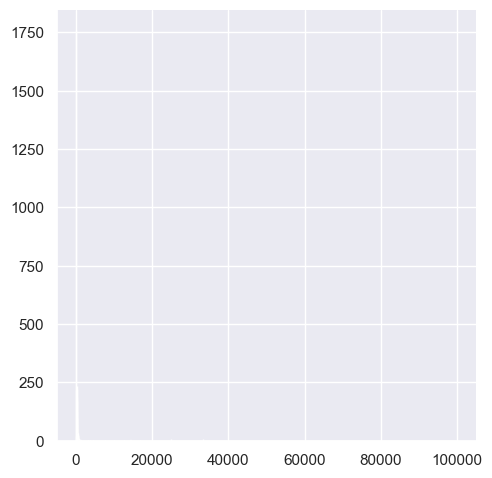

In [9]:
import seaborn as sns

# g = sns.FacetGrid(df, hue="class")
# g.map(sns.disp)
for feature in df.columns[df.columns.str.contains("title|prop_pos") != True]:
    sns.displot(df, x=feature, hue="class")

# df.columns[df.columns.str.contains("title|prop_pos") != True]
# sns.displot(df, x='mean_img', hue="class")
# sns.displot(df, x='mean_conc', hue="class")

,0,1,2
mean_conc,0.073580,-2.071616,1.998036
mean_img,-0.257735,-0.565886,0.823621
mean_freq,-0.614860,2.604023,-1.989163
NOUN,-7.924053,3.765392,4.158661
VERB,-3.859627,-0.794058,4.653685


<BarContainer object of 5 artists>

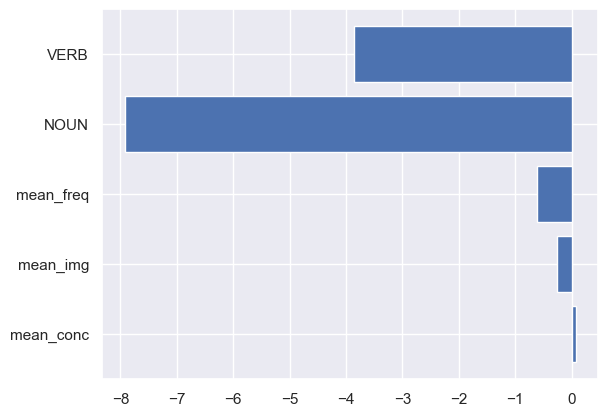

In [ ]:
import matplotlib.pyplot as plt
display_df = pd.DataFrame(pipe['logisticregression'].coef_.T, index=xdf.columns) # type: ignore
display(display_df)

plt.barh(display_df.index, display_df[0])

- Write about lemmatization approaches
- Possibly make a diagram for how the process goes

## Authorship Identification

charles dickens, alexandre dumas, jules verne, lewis caroll, stephen king, isaac asimov

In [10]:
import pandas as pd

csv = "./gutenberg/metadata/metadata.csv"

def open_pg(id: str):
    with open(f"./gutenberg/data/text/{id}_text.txt") as f:
        return f.read()

pg = pd.read_csv(csv)

Uniquely identified authors in Project Gutenberg: 22757
Uniquely identified pieces of literature: 70550
Files not found: 282
Total files: 16459


In [28]:
# results_dict = {}
for author, data in new_texts.items():
    results_dict[author] = process_texts(data)

100%|██████████| 739/739 [01:41<00:00,  7.27it/s] 


In [27]:
new_texts = {}
for i, j in enumerate(texts.items()):
    if i > 10:
        new_texts[j[0]] = j[1]

In [30]:
pg_authorship_id_path = Path('./results/pgauthorship_30.csv')
# results_dict = {}
#     for author, data in texts.items():
#         results_dict[author] = process_texts(data)
pg_df = []
for author, collection in results_dict.items():
    for c in collection:
        try:
            pg_df.append((*c, author))
        except:
            pass
pg_df = pd.DataFrame(pg_df, columns=(*Report._fields, "class"))

# pg_df.to_csv(pg_authorship_id_path)
pg_df.to_pickle()


,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,mean_freq,prop_pos,class
0,PG100_0,20965,3.704031,185.218147,41.245174,0.024708,2.908476,3.732263,-2.223789,"{'NOUN': 0.2649660659957875, 'VERB': 0.1537093...","Shakespeare, William"
1,PG100_1,21734,3.717815,48.203970,11.648635,0.092712,2.949410,3.698330,-2.289138,"{'NOUN': 0.2564331970006817, 'VERB': 0.1487304...","Shakespeare, William"
2,PG100_2,21184,3.821988,41.073917,9.878929,0.111122,3.029351,3.720865,-2.307213,"{'NOUN': 0.2703504622661793, 'VERB': 0.1493872...","Shakespeare, William"
3,PG100_3,20918,3.877092,39.385965,9.372093,0.117172,3.039686,3.715681,-2.274941,"{'VERB': 0.1460537199077097, 'ADJ': 0.05750729...","Shakespeare, William"
4,PG100_4,21054,3.780089,45.727187,10.804255,0.100456,3.033877,3.730971,-2.268388,"{'VERB': 0.1527723075576561, 'ADJ': 0.06183536...","Shakespeare, William"
...,...,...,...,...,...,...,...,...,...,...,...
15278,PG9785_7,20102,4.103124,268.910811,55.259459,0.018406,2.850254,3.738903,-2.204129,"{'NOUN': 0.22869999021813558, 'VERB': 0.167465...","Scott, Walter"
15279,PG9785_8,20565,4.006224,261.207349,54.847769,0.018527,2.831796,3.703673,-2.222307,"{'ADJ': 0.06364549935397426, 'NOUN': 0.2318514...","Scott, Walter"
15280,PG9785_9,21112,3.885515,243.835784,52.612745,0.019326,2.985370,3.737557,-2.264361,"{'ADJ': 0.060467716388707723, 'NOUN': 0.238703...","Scott, Walter"
15281,PG9785_10,20725,3.970181,228.533333,48.505747,0.020989,3.050186,3.857804,-2.219202,"{'NOUN': 0.2453080568720379, 'VERB': 0.1712796...","Scott, Walter"


In [ ]:
pg_authorship_id_path = Path('./results/.pgauthorship.csv')

if pg_authorship_id_path.exists():
    pg_df = pd.read_csv(pg_authorship_id_path)
else:
    authors = pg.groupby(['author'], group_keys=True).count(
    ).sort_values(by=['id'], ascending=False)['id']
    authors = authors.loc[authors.index.str.contains(
        r"Various|Anonymous|Unknown") != True]
    print(f"Uniquely identified authors in Project Gutenberg: {len(authors)}\n" +
        f"Uniquely identified pieces of literature: {len(pg)}")

    texts = {}
    for author in authors.index[:30]:
        texts[author] = []
        for book in list(pg.loc[pg["author"] == author].itertuples()):
            texts[author].append(book.id)

    # for book in list(pg.itertuples())[:5]:
    #     print(book)
    filesnf = 0
    for author, collection in texts.items():
        data = []
        for text in collection:
            try:
                for i, t in enumerate(split_strings(open_pg(text), length=input_length)):
                    data.append((t, f"{text}_{i}"))
            except FileNotFoundError:
                filesnf += 1
        texts[author] = data

    print(f"Files not found: {filesnf}")
    print(f"Total files: {sum(len(i) for i in texts.values())}")
    
    results_dict = {}
    for author, data in texts.items():
        results_dict[author] = process_texts(data)
    pg_df = []
    for author, col in results_dict.items():
        for c in col:
            pg_df.append((*c, author))
    pg_df = pd.DataFrame(pg_df, columns=(*Report._fields, "class"))
    
    pg_df.to_csv(pg_authorship_id_path)


pg_df

,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,mean_freq,prop_pos,author
0,PG100,20965,3.704031,185.218147,41.245174,0.715478,2.908476,3.732263,-2.223789,"{'NOUN': 0.2649660659957875, 'VERB': 0.1537093...","Shakespeare, William"
1,PG1041,21347,3.606408,173.742701,39.598540,0.708249,2.913356,3.749126,-2.208393,"{'NOUN': 0.27880184331797236, 'VERB': 0.146313...","Shakespeare, William"
2,PG1045,12547,3.604686,197.547945,43.732877,0.713398,3.226101,4.136081,-2.137807,"{'NOUN': 0.2690681284259984, 'VERB': 0.1458888...","Shakespeare, William"
3,PG10606,20935,3.742393,100.152107,22.399794,0.736661,2.970679,3.711603,-2.289379,"{'VERB': 0.12507455838495068, 'NOUN': 0.270933...","Shakespeare, William"
4,PG1100,18213,4.025531,64.788130,13.389234,0.768352,3.045187,3.886167,-2.177433,"{'NOUN': 0.27977939281480335, 'ADJ': 0.0575743...","Shakespeare, William"
...,...,...,...,...,...,...,...,...,...,...,...
3825,PG7024,19974,4.124462,182.597786,37.688192,0.615350,2.979215,3.845915,-2.155728,"{'ADJ': 0.06398394282077642, 'NOUN': 0.2067851...","Scott, Walter"
3826,PG7025,19045,4.281596,194.405882,38.319608,0.594067,2.977186,3.933069,-2.129846,"{'NOUN': 0.23972777976769175, 'ADJ': 0.0614542...","Scott, Walter"
3827,PG7853,20074,4.101873,253.137405,51.979644,0.602122,2.983989,3.961618,-2.159975,"{'NOUN': 0.22904836498923048, 'VERB': 0.149158...","Scott, Walter"
3828,PG7987,20400,4.014314,207.442589,43.434238,0.612549,3.018862,3.882210,-2.212138,"{'NOUN': 0.24446046623407836, 'VERB': 0.153472...","Scott, Walter"


In [ ]:
from matplotlib.scale import LogitScale
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Join
df = pd.DataFrame(pg_df,columns=(*Report._fields, "author"))
df = df.join(pd.json_normalize(df["prop_pos"]).fillna(0.0))  # type: ignore
df.mean_freq = - df.mean_freq
df.author = df.author.astype('category')
df = df.rename(columns={'author':'class'})


# drop unneeded columns and select features
xdf = df.drop(["title", "class", "prop_pos"], axis=1)

# drop arbitrary columns to see how results change
xdf = xdf.drop([
    # "nwords",
    # "mean_wl",
    # "mean_sl",

    # "NOUN",
    # "ADJ",
    # "VERB",
    # "mean_conc", "mean_img", "mean_freq",

    # "prop_contentwords",
    # "mean_tokenspersent"
], axis=1)
ydf = df["class"]

# make the splits
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, test_size=0.1)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1)

# create the pipeline
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
pipe.fit(xtrain, ytrain)  # apply scaling on training data


# test the scoring
print(f"Val split score: {pipe.score(xval, yval):.5f}")
print(f"Test split score: {pipe.score(xtest, ytest):.5f}")

# confusion_matrix(pipe.predict(xtest), ytest)


Val split score: 0.53913
Test split score: 0.52480
